In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
# Try importing tqdm for progress bar

try:
    from tqdm import tqdm
    
except ImportError:
    # Substitute dummy function if not available
    def tqdm(iterable, *args, **kwargs):
        return iterable

In [9]:
from Bio.Seq import Seq

# Import seqanalysis.py

Replace this with the correct file path for your system.

In [4]:
run ~/git/buds-ucsf-2017/sequence_analysis/seqanalysis.py

# Open files

In [5]:
# Edit this
data_dir = '/Users/student/projects/pubs/seq/'

In [6]:
files = [data_dir + 'R{}_sample200x.fastq'.format(i + 1) for i in range(3)]

In [7]:
triplets = list(tqdm(zip_reads(files, 'fastq'), total=100_000))

 98%|█████████▊| 98044/100000 [00:11<00:00, 8664.59it/s] 


In [10]:
with open(data_dir + 'wt_seq.txt') as fobj:
    wt_seq = Seq(fobj.read())

In [12]:
read_stats = pd.read_csv('read_stats.csv', index_col=[0, 1])

# Alignments

In [29]:
def sliding_alignment(ref, read, min_qual=20):
    l1, l2 = map(len, [ref, read])
    
    ltotal = l1 + l2 - 1
    lmin = min(l1, l2)
    
    # match, mismatch, ignored, len
    counts = np.zeros((4, ltotal))
    
    phred = read.letter_annotations['phred_quality']
    
    for i in range(ltotal):
        start1 = max(0, i - l2 + 1)
        start2 = max(0, l2 - 1 - i)
        
        for j, (c1, c2, q) in enumerate(zip(ref[start1:], read.seq[start2:], phred)):
            if c2 == 'N' or q < min_qual:
                counts[2, i] += 1
            elif c1 == c2:
                counts[0, i] += 1
            else:
                counts[1, i] += 1
    
    counts[3] = counts[:3].sum(axis=0)
                
    return counts

In [40]:
def plot_counts(counts, rel=False, legend=True, ax=None):
    
    if ax is None:
        ax = plt.gca()
    
    names = ['matches', 'mismatches', 'filtered', 'aligned len']
    if rel:
        names = names[:3]

    for c, label in zip(counts, names):
        if rel:
            c = c / counts[3]
        ax.plot(c, label=label)

    if legend:
        ax.legend(loc='upper left')

### Find best candidates

In [23]:
r1_good = read_stats[(read_stats.index.get_level_values('read') == 1) & (read_stats['n_count'] == 0)].index
r3_good = read_stats[(read_stats.index.get_level_values('read') == 3) & (read_stats['n_count'] == 0)].index

In [26]:
r1_best = read_stats.loc[r1_good, 'mean_quality'].sort_values(ascending=False)
r3_best = read_stats.loc[r3_good, 'mean_quality'].sort_values(ascending=False)

### Try aligning

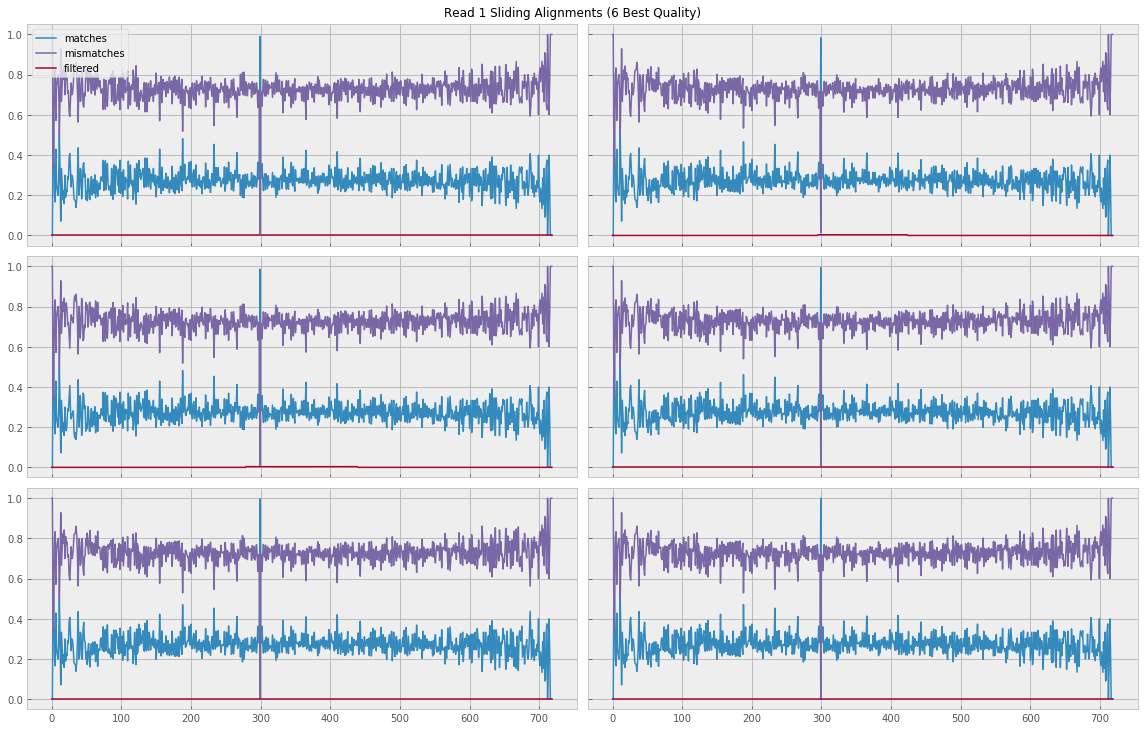

In [48]:
fig, axes = plt.subplots(3, 2, figsize=(16, 10), sharex=True, sharey=True)

for i, ax in zip(r1_best.index.get_level_values('triplet'), axes.flat):
    read = triplets[i][0]
    counts = sliding_alignment(wt_seq, read)
    plot_counts(counts, rel=True, ax=ax, legend=ax is axes[0, 0])

plt.suptitle('Read 1 Sliding Alignments (6 Best Quality)', y=1.01)
plt.tight_layout()

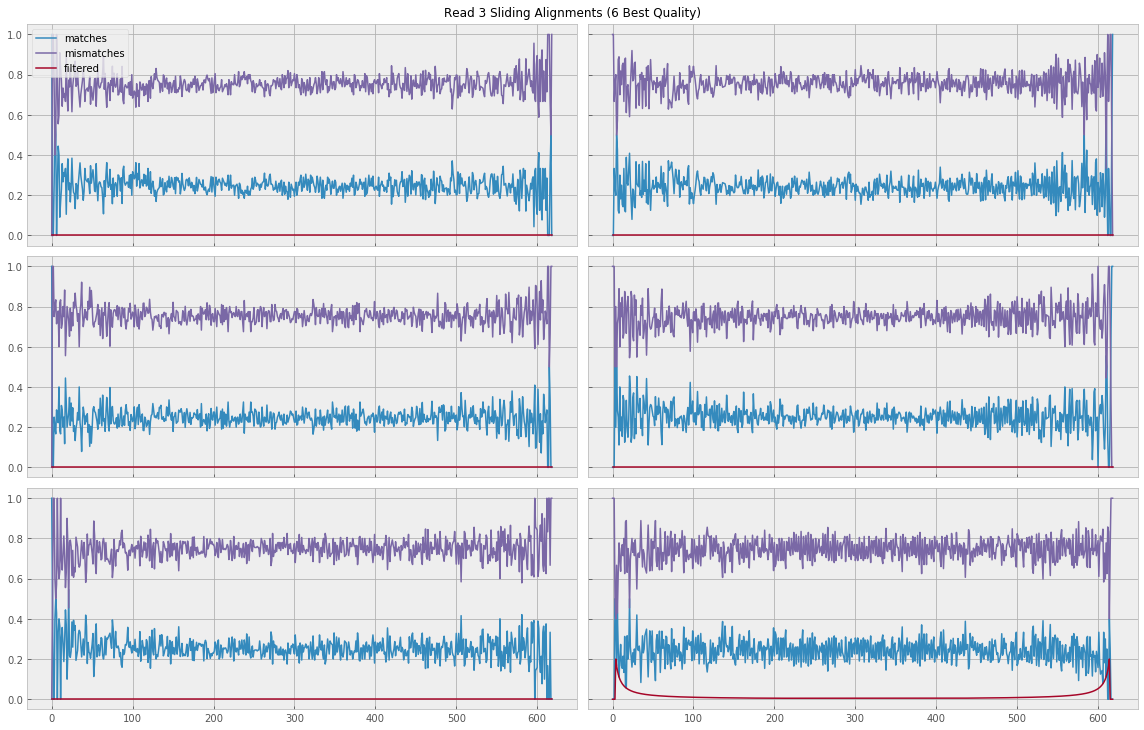

In [49]:
fig, axes = plt.subplots(3, 2, figsize=(16, 10), sharex=True, sharey=True)

for i, ax in zip(r3_best.index.get_level_values('triplet'), axes.flat):
    read = triplets[i][2]
    counts = sliding_alignment(wt_seq, read)
    plot_counts(counts, rel=True, ax=ax, legend=ax is axes[0, 0])

plt.suptitle('Read 3 Sliding Alignments (6 Best Quality)', y=1.01)
plt.tight_layout()